# SVM

SVM is a powerful method if we want to perform a classification task. Given that we have many datapoints compared to the number of features, solving the primal problem is more appropriate.

In addition, we added some modification to the usual SVM method: during the training, we penalize more strongly errors regarding the label "+1" as it appears way less frequently than the "-1". This is done to push our model to have better F1-score (a metric that takes into account the unequal distribution of "+1" and "-1" labels).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utilities.helpers import *
from utilities.Data_preprocessing_global import *
from utilities.Hyperparameters_SVM import *
from implementations import *

### Importing the data

In [2]:
# You have to change the path for it to work
#data_path = r'C:\Users\natha\Documents\EPFL\Cours_MA1\ML\ML_course\projects\project1 - withGit\data\dataset'
data_path = "D:\\EPFL\\MA1\\Machine Learning\\Projet 1\\dataset"

In [3]:
x_train, x_test, y_train, train_ids, test_ids, headers_train = load_csv_data(data_path, sub_sample=False)

test


### Pre-processing the data

In [4]:
x_tr, x_val, y_tr, y_val, x_train_full, x_test_formatted, remaining_headers = data_preprocess(x_train, y_train, x_test, headers_train, model_labels = {-1, 1}, ratio_miss = 0.1, ratio_train = 1, standardization = True)

See the different shapes : x_train (328135, 321), x_test (109379, 321), y_train (328135,), headers_train: 321
After preprocessing (train) : column with missing values {}, are there NaN ? False
After preprocessing (test) : column with missing values {}, are there NaN ? False
See the different shapes : x_tr (328135, 169), x_val (0, 169), y_tr (328135,), y_te(0,), x_test_formatted(109379, 169)


We intentionally select a split training vs validation of 100% vs 0% because this split will be done inside the K-Fold cross-validation.

### Hyperparameter tuning 

We increase the iteration with gamma, because we observed in our testing that as the gamma decreased the iteration to converge were higher. And as we did not want to iterate for no significant improvement for the higher step size, we add that the maximum number of iteration is dependant on the gamma.

In [8]:
# Hyperparameters we choose to test
k_fold = 5
penalty_factor_list = [8, 9, 10, 11, 12, 13]
gamma_list = [0.1, 0.01]
lambda_list = [0.1, 0.01, 0.001]
a_list = [0.5, 0.75] # Power of the denominator in the decreasing step size

results = Hyperparameter(x_tr, y_tr, penalty_factor_list, gamma_list, lambda_list, a_list, k_fold)

We save the information from our grid-search + K-Fold in a csv file, to later analyse them.

In [9]:
import csv

# Specify the file path where you want to save the CSV file
file_path = 'results.csv'

# Write the list of dictionaries to the CSV file
with open(file_path, 'w', newline='') as csv_file:
    fieldnames = results[0].keys()  # Get the field names from the first dictionary
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()  # Write the header
    writer.writerows(results)  # Write the data

print(f"Results saved to {file_path}")

Results saved to results.csv


In [10]:
best_f1_score, best_params = Get_best_results(results)

Best F1-Score: 0.3502768799667791
Best Parameters and Metrics: {'penalty_factor': 10, 'gamma': 0.01, 'lambda': 0.01, 'a': 0.5}


### Training the model

Now that we have found the best hyperparameters, we can use them to train our model one last time, on the whole dataset.

In [ ]:
penalty_factor = 10
gamma = 0.01
lambda_ = 0.01
a = 0.5
max_iter = int(10 / gamma)

w_opt, loss_tr = sgd_for_svm(y_tr, x_tr, max_iter, gamma, lambda_, a, penalty_factor)

Evaluate performance on the training set:

In [12]:
y_pred, accuracy, precision, recall, f1_score = evaluate_performance(x_tr, y_tr, w_opt, model_labels={-1, 1}, limit=0)
print(accuracy)
print(f1_score)

0.762497142944215
0.36514414656598


### Effect of the parameter on the results 

To evalaute the effect of the parameters on the results, we take the parameter of our best submission and vary one of them.

#### Learning Rate

In [5]:
k_fold = 5
penalty_factor = 10
a = 0.5
lambda_ = 0.01

gamma_liste = [0.5 ,0.1, 0.05, 0.01, 0.005] # 0.001 prend 1000 ans
results_gamma = np.zeros((len(gamma_liste)))

for idx, gamma in enumerate(gamma_liste):
    print(f"Iteration {idx + 1}, evaluating gamma = {gamma}") 
    max_iter = int(10 / gamma)
    av_f1_score, av_loss_tr, av_loss_te = cross_validation_demo(
                        x=x_tr,
                        y=y_tr,
                        k_fold=k_fold,
                        lambda_=lambda_,
                        a=a,
                        penalty_factor=penalty_factor,
                        max_iters=max_iter,
                        gamma=gamma)
    results_gamma[idx] = av_f1_score

Iteration 1, evaluating gamma = 0.5
Iteration 2, evaluating gamma = 0.1
Iteration 3, evaluating gamma = 0.05
Iteration 4, evaluating gamma = 0.01
Iteration 5, evaluating gamma = 0.005


#### Regularization term

In [6]:
k_fold = 5
penalty_factor = 10
a = 0.5
gamma = 0.01
max_iter = int(10 / gamma)

lambda_liste = [1, 0.1,0.01, 0.001, 0.0001]
results_lambda = np.zeros((len(lambda_liste)))

for idx, lambda_ in enumerate(lambda_liste):
    print(f"Iteration {idx + 1}, evaluation gamma = {lambda_}") 
    av_f1_score, av_loss_tr, av_loss_te = cross_validation_demo(
                        x=x_tr,
                        y=y_tr,
                        k_fold=k_fold,
                        lambda_=lambda_,
                        a=a,
                        penalty_factor=penalty_factor,
                        max_iters=max_iter,
                        gamma=gamma)
    results_lambda[idx] = av_f1_score

Iteration 1, evaluation gamma = 1
Iteration 2, evaluation gamma = 0.1
Iteration 3, evaluation gamma = 0.01
Iteration 4, evaluation gamma = 0.001
Iteration 5, evaluation gamma = 0.0001


### Penalty factor

In [17]:
k_fold = 5
a = 0.5
lambda_ = 0.01
gamma = 0.01
max_iter = int(10 / gamma)

penalty_factor_liste = [1,5,10,15,20]
results_penalty = np.zeros((len(penalty_factor_liste)))

for idx, penalty_factor in enumerate(penalty_factor_liste):
    print(f"Iteration {idx + 1}, evaluating gamma = {penalty_factor}") 
    av_f1_score, av_loss_tr, av_loss_te = cross_validation_demo(
                        x=x_tr,
                        y=y_tr,
                        k_fold=k_fold,
                        lambda_=lambda_,
                        a=a,
                        penalty_factor=penalty_factor,
                        max_iters=max_iter,
                        gamma=gamma)
    results_penalty[idx] = av_f1_score

Iteration 1, evaluating gamma = 1
Iteration 2, evaluating gamma = 5
Iteration 3, evaluating gamma = 10
Iteration 4, evaluating gamma = 15
Iteration 5, evaluating gamma = 20


#### PLots

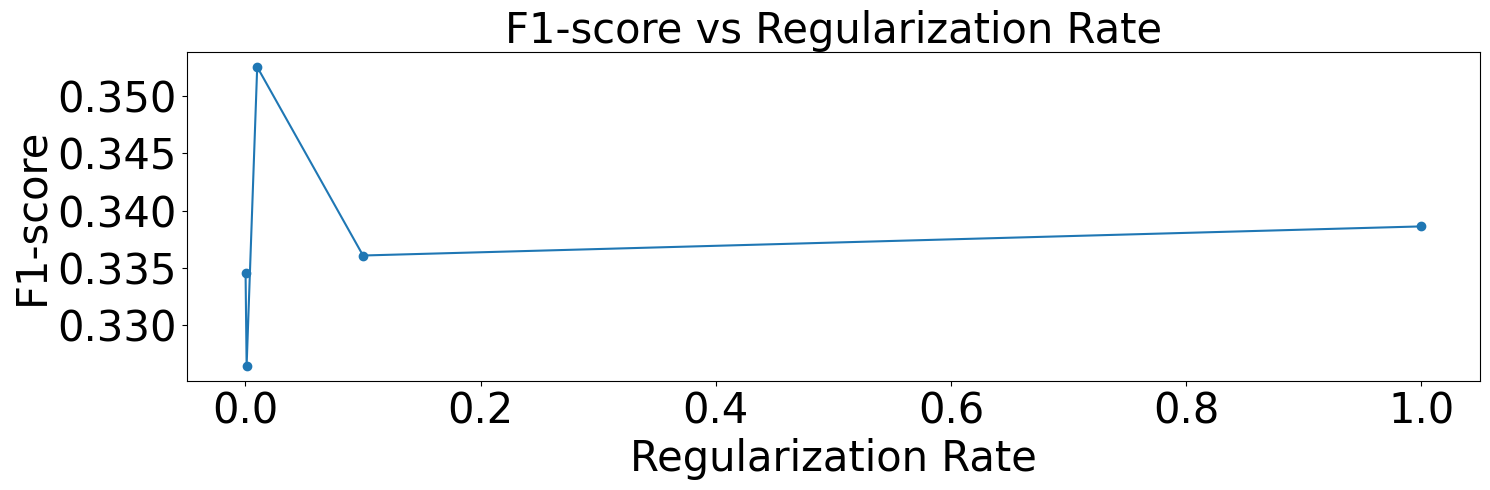

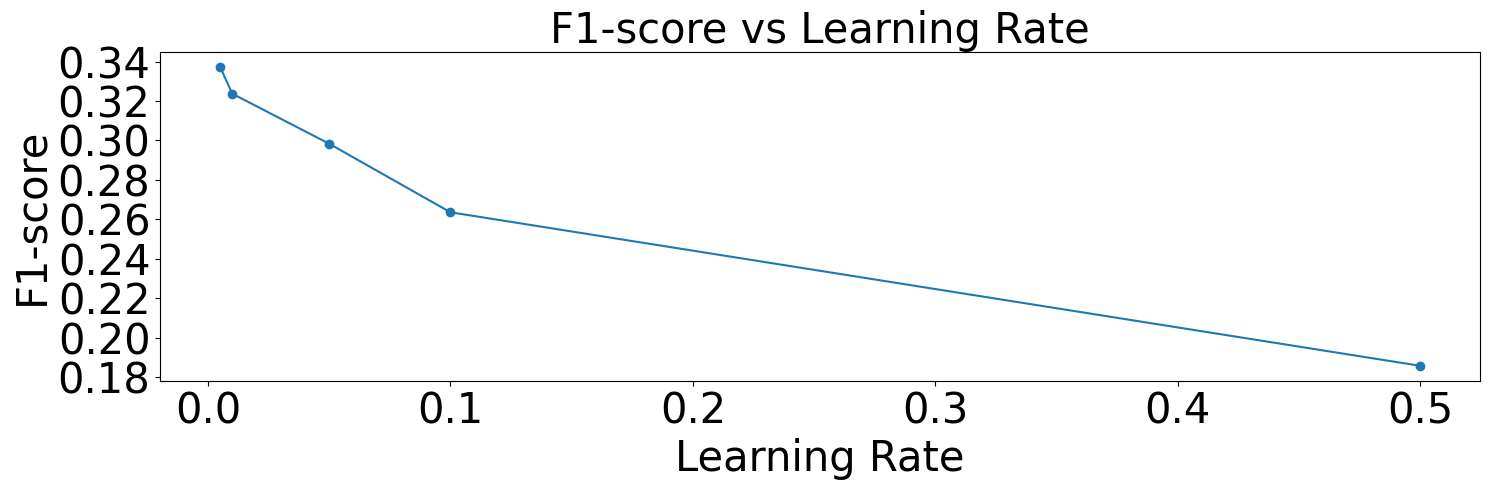

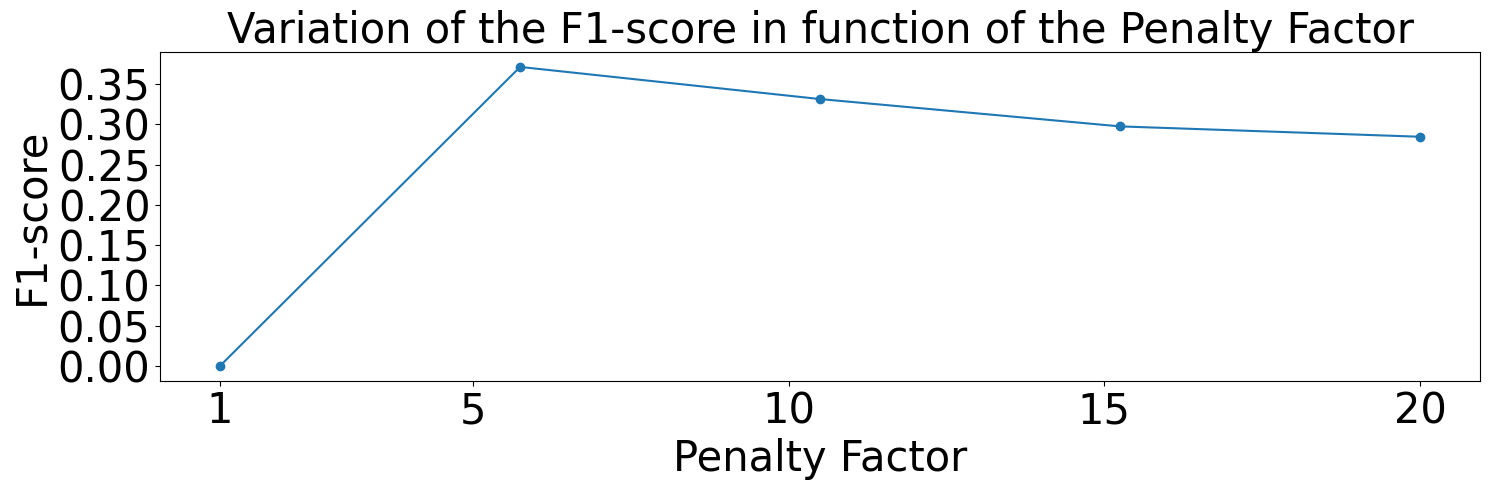

In [18]:
# First figure
plt.figure(figsize=(15, 5))
plt.plot(lambda_liste[::-1], results_lambda[::-1], marker='o')
plt.title("F1-score vs Regularization Rate", fontsize=30)
plt.xlabel("Regularization Rate", fontsize=30)
plt.ylabel("F1-score", fontsize=30)
plt.xticks(fontsize=30)  # Set x-tick labels font size
plt.yticks(fontsize=30)  # Set y-tick labels font size
plt.tight_layout()
plt.savefig("F1_score_vs_Regularization_Rate.png")
plt.show()

# Second figure
plt.figure(figsize=(15, 5))
plt.plot(gamma_liste[::-1], results_gamma[::-1], marker='o')
plt.title("F1-score vs Learning Rate", fontsize=30)
plt.xlabel("Learning Rate", fontsize=30)
plt.ylabel("F1-score", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.savefig("F1_score_vs_Learning_Rate.png")
plt.show()

# Third figure
plt.figure(figsize=(15, 5))
plt.plot(np.linspace(np.min(penalty_factor_liste), np.max(penalty_factor_liste), len(penalty_factor_liste)), results_penalty, marker='o')
plt.title("Variation of the F1-score in function of the Penalty Factor", fontsize=30)
plt.xlabel("Penalty Factor", fontsize=30)
plt.ylabel("F1-score", fontsize=30)
plt.xticks(penalty_factor_liste, fontsize=30)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.savefig("F1_score_vs_Penalty_Factor.png")
plt.show()

### Submission

In [14]:
best_limit = 0 #It doesn't matter here, if we say that the model_labels are {-1, 1}
best_w = w_opt
name = 'best_SVM_submission_file.csv'
model_labels = {-1, 1}

y_pred_test = submission(x_test_formatted, test_ids, best_limit, best_w, name, model_labels)

### Bonus: comparison between having a penalty factor and using the regular weighting

To see the difference, we make a split training vs validation

In [13]:
x_tr, x_val, y_tr, y_val, x_train_full, x_test_formatted, remaining_headers = data_preprocess(x_train, y_train, x_test, headers_train, model_labels = {-1, 1}, ratio_miss = 0.1, ratio_train = 0.8, standardization = True)

See the different shapes : x_train (328135, 321), x_test (109379, 321), y_train (328135,), headers_train: 321
After preprocessing (train) : column with missing values {}, are there NaN ? False
After preprocessing (test) : column with missing values {}, are there NaN ? False
See the different shapes : x_tr (262508, 169), x_val (65627, 169), y_tr (262508,), y_te(65627,), x_test_formatted(109379, 169)


With higher penalization of +1 misclassification:

In [16]:
gamma = 0.01
max_iter = int(10 / gamma)
lambda_ = 0.01
a = 0.5
penalty_factor = 10

w_opt, loss_tr = sgd_for_svm(y_tr, x_tr, max_iter, gamma, lambda_, a, penalty_factor)

In [17]:
y_pred, accuracy, precision, recall, f1_score = evaluate_performance(x_val, y_val, w_opt, model_labels={-1, 1}, limit=0)
print(f1_score)

0.34311801689960353


With regular penalization:

In [18]:
gamma = 0.01
max_iter = int(10 / gamma)
lambda_ = 0.001
a = 0.1
penalty_factor = 1

w_opt, loss_tr = sgd_for_svm(y_tr, x_tr, max_iter, gamma, lambda_, a, penalty_factor)

In [19]:
y_pred, accuracy, precision, recall, f1_score = evaluate_performance(x_val, y_val, w_opt, model_labels={-1, 1}, limit=0)
print(f1_score)

0.15450264861683344
